# Imports and General Settings

In [1]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import model_arch_utility as model_arch
import log_utility as log_util
import data_augmentation_utility as da_util
import load_data_utility as load_data_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


/device:GPU:0


# Data Augmentation

In [2]:
# data augmentation methods in data_augmentation_utility.py

# choose augmentation in load_data_utility.py

# ConvNet

## ConvNet Architecture

In [3]:
num_classes = 3

# ResNet-10 architecture
def convnet_network(x, conv_kernels=[10,7,3], num_channels=8, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('ConvNet', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        counter = 0
        for kernel in conv_kernels:
        
            x = model_arch.conv(x, num_channels, kernel=kernel, stride=2, padding='SAME', scope='conv_' + str(counter))
            x = model_arch.relu(x)
            
#             x = model_arch.max_pooling(x)
            
            x = model_arch.batch_norm(x, is_training, scope='batch_norm_' + str(counter))
            
            filtered_images.append(tf.identity(x))
            
            counter = counter + 1
            num_channels = num_channels * 2
 
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def convnet_model_fn(features, labels, mode, conv_kernels=[10,7,3], num_channels=8, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = convnet_network(features,
                                                                          conv_kernels=conv_kernels,
                                                                          num_channels=num_channels,
                                                                          n_classes=num_classes,
                                                                          reuse=False,
                                                                          is_training=True)
        
        logits_test, activ_maps_test, _ = convnet_network(features,
                                                          conv_kernels=conv_kernels,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)


        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(activ_maps_train), labels, 20.0, True)
        
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        if (not log):
            tf.summary.scalar("loss", loss_op)
            tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

#             conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

#             plot_op_expanded = tf.expand_dims(log_util.plot_conv_weights(conv0_weights), 0)
#             tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    name = "after_conv_" + str(counter)
                    if counter == 0:
                        name = "original_image:"
                    
                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(log_util.plot_conv_output(activation_map, name), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 2)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

## Experimentation

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.summary.FileWriterCache.clear()
b_size = 32

learning_rate = 0.001

random_seed = 777

random.seed(a=random_seed)

num_steps = 10000

# convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_data_aug_no_norm/"

convnet_checkpoint_path_base = "/data/jma/model/cnn_v1/snnl_experiments/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

# kernel_sizes = [[10, 7, 3]] v1

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0, 0.1, 0.4]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


dataset_root = "./data/generated_splits/"

sets = ["ali_relabeled_original", "peter_relabeled_original", "ali_relabeled_undersampled", "peter_relabeled_undersampled"]


for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                train_root = dataset_root + dt_set + "/train/"
                eval_root = dataset_root + dt_set + "/eval/"
               
                train_paths = load_data_util.load_image_paths(train_root)
                random.shuffle(train_paths)

                print(train_root)
                
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                train_input_fn = lambda : load_data_util.load(train_root, train_paths, training=True, augment=False, batch_size=32, norm=False, shuffle=False)
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                model_path = convnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
                print(model_path)

                config = tf.estimator.RunConfig(
                    log_step_count_steps= 20,
                    save_summary_steps= 30,
                    save_checkpoints_secs= 30,
                    model_dir=model_path,
                    tf_random_seed=random_seed,
                    session_config=session_config)

                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, config=config)

                train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
                eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=30)

                tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

        

./data/generated_splits/ali_relabeled_original/train/
/data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 30, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7b7876b630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running tr

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 646: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-646
INFO:tensorflow:global_step/sec: 3.81664
INFO:tensorflow:loss = 1.8070341e-05, step = 660 (5.240 sec)
INFO:tensorflow:global_step/sec: 5.59161
INFO:tensorflow:loss = 3.6103713e-05, step = 680 (3.576 sec)
INFO:tensorflow:global_step/sec: 5.32372
INFO:tensorflow:loss = 4.9862552e-05, step = 700 (3.756 sec)
INFO:tensorflow:global_step/sec: 5.64188
INFO:tensorflow:loss = 2.4325643e-06, step = 720 (3.546 sec)
INFO:tensorflow:global_step/sec: 5.55091
INFO:tensorflow:loss = 6.995513e-06, step = 740 (3.603 sec)
INFO:tensorflow:global_step/sec: 5.87112
INFO:tensorflow:loss = 3.063298e-05, step = 760 (3.405 sec)
INFO:tensorflow:global_step/sec: 5.46497
INFO:tensorflow:loss = 1.4477201e-05, step = 780 (3.661 sec)
INFO:tensorflow:global_step/sec: 5.58843
INFO:tensorflow:loss = 1.0787085e-05, step = 800 (3.578 sec)
INFO:tensorflow:Saving

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:01:20
INFO:tensorflow:Saving dict for global step 1447: accuracy = 0.63981044, global_step = 1447, loss = 5.1355715
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1447: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-1447
INFO:tensorflow:global_step/sec: 3.75857
INFO:tensorflow:loss = 8.760674e-06, step = 1460 (5.320 sec)
INFO:tensorflow:global_step/sec: 5.48508
INFO:tensorflow:loss = 3.0268706e-05, step = 1480 (3.646 sec)
INFO:tensorflow:global_step/sec: 5.40941
INFO:tensorflow:loss = 1.7772254e-05, step = 1500 (3.699 sec)
INFO:tensorflow:global_step/sec: 5.80049
INFO:tensorflow:loss = 6.5002014e-06, step = 1520 (3.446 sec)
INFO:tensorflow:global_step/sec: 5.45832
INFO:tensorflow:loss = 1.1000115e-05, step = 1540 (3.664 sec)
INFO:tensorflow:global_step/sec: 5.7731
INFO:tensorflow:loss = 1.8795961e-05, step = 1560 (3.468 sec)
INFO:

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:03:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-2275
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:03:50
INFO:tensorflow:Saving dict for global step 2275: accuracy = 0.63981044, global_step = 2275, loss = 5.133361
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2275: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-2275
INFO:tensorflow:global_step/sec: 3.83115
INFO:tensorflow:loss = 5.051175e-06, step = 2280 (5.220 sec)
INFO:tensorflow:global_step/sec: 6.39494
INFO:tensorflow:loss = 1.5723828e-05, step = 2300 (3.126 sec)
INFO:tensorflow:global_step/sec: 5.90208
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 6.13778
INFO:tensorflow:loss = 3.7028701e-06, step = 3060 (3.259 sec)
INFO:tensorflow:global_step/sec: 5.66813
INFO:tensorflow:loss = 2.5219879e-06, step = 3080 (3.528 sec)
INFO:tensorflow:global_step/sec: 5.61243
INFO:tensorflow:loss = 7.640324e-06, step = 3100 (3.563 sec)
INFO:tensorflow:Saving checkpoints for 3111 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:06:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-3111
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:06:21
INFO:tensorflow:Saving dict for global step 3111: accuracy = 0.6445498, global_step = 3111, 

INFO:tensorflow:loss = 2.7417786e-06, step = 3800 (5.336 sec)
INFO:tensorflow:global_step/sec: 6.97092
INFO:tensorflow:loss = 1.8626247e-06, step = 3820 (2.869 sec)
INFO:tensorflow:global_step/sec: 5.99227
INFO:tensorflow:loss = 3.6991562e-06, step = 3840 (3.341 sec)
INFO:tensorflow:global_step/sec: 6.07314
INFO:tensorflow:loss = 2.8945078e-06, step = 3860 (3.290 sec)
INFO:tensorflow:global_step/sec: 5.83645
INFO:tensorflow:loss = 7.5995285e-07, step = 3880 (3.427 sec)
INFO:tensorflow:global_step/sec: 6.24415
INFO:tensorflow:loss = 0.0, step = 3900 (3.204 sec)
INFO:tensorflow:global_step/sec: 6.15205
INFO:tensorflow:loss = 5.651157e-06, step = 3920 (3.250 sec)
INFO:tensorflow:global_step/sec: 6.87444
INFO:tensorflow:loss = 4.6043933e-06, step = 3940 (2.909 sec)
INFO:tensorflow:global_step/sec: 6.38156
INFO:tensorflow:loss = 2.7567103e-07, step = 3960 (3.135 sec)
INFO:tensorflow:Saving checkpoints for 3971 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:10:51
INFO:tensorflow:Saving dict for global step 4659: accuracy = 0.6445498, global_step = 4659, loss = 5.127582
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4659: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-4659
INFO:tensorflow:global_step/sec: 3.48882
INFO:tensorflow:loss = 1.8216539e-06, step = 4660 (5.731 sec)
INFO:tensorflow:global_step/sec: 7.34459
INFO:tensorflow:loss = 2.2388756e-06, step = 4680 (2.725 sec)
INFO:tensorflow:global_step/sec: 6.04239
INFO:tensorflow:loss = 4.2950915e-06, step = 4700 (3.308 sec)
INFO:tensorflow:global_step/sec: 6.058
INFO:tensorflow:loss = 1.0877802e-06, step = 4720 (3.301 sec)
INFO:tensorflow:global_step/sec: 5.80858
INFO:tensorflow:loss = 1.7322482e-06, step = 4740 (3.445 sec)
INFO:tensorflow:global_step/sec: 5.95359
INFO:tensorflow:loss = 1.36344

INFO:tensorflow:global_step/sec: 6.33864
INFO:tensorflow:loss = 1.2367901e-06, step = 5500 (3.155 sec)
INFO:tensorflow:global_step/sec: 6.94597
INFO:tensorflow:loss = 1.3261941e-06, step = 5520 (2.880 sec)
INFO:tensorflow:Saving checkpoints for 5540 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:13:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-5540
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:13:21
INFO:tensorflow:Saving dict for global step 5540: accuracy = 0.6492891, global_step = 5540, loss = 5.130015
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5540: /data/jma/model

INFO:tensorflow:global_step/sec: 3.85201
INFO:tensorflow:loss = 2.3022067e-06, step = 6260 (5.191 sec)
INFO:tensorflow:global_step/sec: 6.99007
INFO:tensorflow:loss = 6.109457e-07, step = 6280 (2.862 sec)
INFO:tensorflow:global_step/sec: 6.49486
INFO:tensorflow:loss = 4.805609e-07, step = 6300 (3.081 sec)
INFO:tensorflow:global_step/sec: 6.38405
INFO:tensorflow:loss = 8.568111e-07, step = 6320 (3.132 sec)
INFO:tensorflow:global_step/sec: 6.51383
INFO:tensorflow:loss = 1.9110641e-06, step = 6340 (3.070 sec)
INFO:tensorflow:global_step/sec: 6.43002
INFO:tensorflow:loss = 3.0174778e-07, step = 6360 (3.112 sec)
INFO:tensorflow:global_step/sec: 6.31166
INFO:tensorflow:loss = 9.201432e-07, step = 6380 (3.167 sec)
INFO:tensorflow:global_step/sec: 6.61219
INFO:tensorflow:loss = 3.2037372e-07, step = 6400 (3.025 sec)
INFO:tensorflow:global_step/sec: 6.31855
INFO:tensorflow:loss = 1.0020988e-06, step = 6420 (3.166 sec)
INFO:tensorflow:Saving checkpoints for 6436 into /data/jma/model/cnn_v1/snnl_

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:17:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-7161
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:17:52
INFO:tensorflow:Saving dict for global step 7161: accuracy = 0.6540284, global_step = 7161, loss = 5.136557
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7161: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-7161
INFO:tensorflow:global_step/sec: 3.62891
INFO:tensorflow:loss = 4.395832e-07, step = 7160 (5.510 sec)
INFO:tensorflow:global_step/sec: 8.96185
INFO:tensorflow:loss = 3.986055e-07, step = 7180 (2.232 sec)
INFO:tensorflow:global_step/sec: 6.62176
INFO:tensorflow:loss 

INFO:tensorflow:global_step/sec: 6.00518
INFO:tensorflow:loss = 1.1101333e-06, step = 7940 (3.329 sec)
INFO:tensorflow:global_step/sec: 6.52901
INFO:tensorflow:loss = 8.9406946e-08, step = 7960 (3.064 sec)
INFO:tensorflow:global_step/sec: 6.39022
INFO:tensorflow:loss = 3.129241e-07, step = 7980 (3.131 sec)
INFO:tensorflow:global_step/sec: 6.67873
INFO:tensorflow:loss = 2.048906e-07, step = 8000 (2.993 sec)
INFO:tensorflow:global_step/sec: 6.3345
INFO:tensorflow:loss = 2.9057213e-07, step = 8020 (3.157 sec)
INFO:tensorflow:global_step/sec: 6.41146
INFO:tensorflow:loss = 1.7881356e-07, step = 8040 (3.120 sec)
INFO:tensorflow:global_step/sec: 6.37697
INFO:tensorflow:loss = 5.8486955e-07, step = 8060 (3.136 sec)
INFO:tensorflow:Saving checkpoints for 8072 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:20:2

INFO:tensorflow:Starting evaluation at 2019-08-19-23:22:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-8810
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:22:23
INFO:tensorflow:Saving dict for global step 8810: accuracy = 0.6635071, global_step = 8810, loss = 5.1455154
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8810: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-8810
INFO:tensorflow:global_step/sec: 4.22139
INFO:tensorflow:loss = 2.4959428e-07, step = 8820 (4.739 sec)
INFO:tensorflow:global_step/sec: 6.58643
INFO:tensorflow:loss = 4.507595e-07, step = 8840 (3.035 sec)
INFO:tensorflow:global_step/sec: 6.42189
INFO:tensorflow:loss = 2.3469286e-07, step = 8860 (3.114 sec)
INFO:tensorflow:global_step/sec: 6.45283
I

INFO:tensorflow:global_step/sec: 6.21551
INFO:tensorflow:loss = 3.539023e-07, step = 9620 (3.216 sec)
INFO:tensorflow:global_step/sec: 6.74108
INFO:tensorflow:loss = 2.2351725e-07, step = 9640 (2.967 sec)
INFO:tensorflow:global_step/sec: 5.89908
INFO:tensorflow:loss = 2.4214364e-07, step = 9660 (3.391 sec)
INFO:tensorflow:global_step/sec: 6.05559
INFO:tensorflow:loss = 3.3155052e-07, step = 9680 (3.304 sec)
INFO:tensorflow:Saving checkpoints for 9701 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:24:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.0/model.ckpt-9701
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-1

INFO:tensorflow:global_step/sec: 3.32884
INFO:tensorflow:loss = 0.34336817, step = 200 (6.007 sec)
INFO:tensorflow:global_step/sec: 5.98773
INFO:tensorflow:loss = 0.10265192, step = 220 (3.340 sec)
INFO:tensorflow:global_step/sec: 6.89083
INFO:tensorflow:loss = 0.09513599, step = 240 (2.904 sec)
INFO:tensorflow:global_step/sec: 6.15091
INFO:tensorflow:loss = 0.10241559, step = 260 (3.250 sec)
INFO:tensorflow:global_step/sec: 5.82895
INFO:tensorflow:loss = 0.09096585, step = 280 (3.431 sec)
INFO:tensorflow:global_step/sec: 6.30773
INFO:tensorflow:loss = 0.10194174, step = 300 (3.172 sec)
INFO:tensorflow:global_step/sec: 6.27812
INFO:tensorflow:loss = 0.10148882, step = 320 (3.185 sec)
INFO:tensorflow:global_step/sec: 6.17076
INFO:tensorflow:loss = 0.099592954, step = 340 (3.241 sec)
INFO:tensorflow:Saving checkpoints for 351 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done c

INFO:tensorflow:loss = 0.09498364, step = 1100 (3.048 sec)
INFO:tensorflow:global_step/sec: 6.06158
INFO:tensorflow:loss = 0.103892915, step = 1120 (3.299 sec)
INFO:tensorflow:global_step/sec: 6.30509
INFO:tensorflow:loss = 0.10520117, step = 1140 (3.173 sec)
INFO:tensorflow:global_step/sec: 5.83592
INFO:tensorflow:loss = 0.09852659, step = 1160 (3.426 sec)
INFO:tensorflow:global_step/sec: 6.09979
INFO:tensorflow:loss = 0.094976164, step = 1180 (3.279 sec)
INFO:tensorflow:global_step/sec: 5.81968
INFO:tensorflow:loss = 0.10238202, step = 1200 (3.437 sec)
INFO:tensorflow:global_step/sec: 6.08968
INFO:tensorflow:loss = 0.09077346, step = 1220 (3.285 sec)
INFO:tensorflow:Saving checkpoints for 1226 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:29:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Re

INFO:tensorflow:Finished evaluation at 2019-08-19-23:31:19
INFO:tensorflow:Saving dict for global step 1932: accuracy = 0.6492891, global_step = 1932, loss = 5.0656624
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1932: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt-1932
INFO:tensorflow:global_step/sec: 3.94167
INFO:tensorflow:loss = 0.09954787, step = 1940 (5.068 sec)
INFO:tensorflow:global_step/sec: 6.01158
INFO:tensorflow:loss = 0.10384896, step = 1960 (3.327 sec)
INFO:tensorflow:global_step/sec: 6.1636
INFO:tensorflow:loss = 0.10825068, step = 1980 (3.248 sec)
INFO:tensorflow:global_step/sec: 5.96941
INFO:tensorflow:loss = 0.09494744, step = 2000 (3.347 sec)
INFO:tensorflow:global_step/sec: 6.10879
INFO:tensorflow:loss = 4.7683727e-08, step = 2020 (3.274 sec)
INFO:tensorflow:global_step/sec: 5.63805
INFO:tensorflow:loss = 0.094969094, step = 2040 (3.549 sec)
INFO:tensorflow:global_step/sec: 5.81641
INFO:tensorflow:loss =

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:33:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt-2784
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:33:49
INFO:tensorflow:Saving dict for global step 2784: accuracy = 0.6540284, global_step = 2784, loss = 5.062114
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2784: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt-2784
INFO:tensorflow:global_step/sec: 3.75541
INFO:tensorflow:loss = 0.10562324, step = 2800 (5.319 sec)
INFO:tensorflow:global_step/sec: 5.99238
INFO:tensorflow:loss = 0.09901402, step = 2820 (3.340 sec)
INFO:tensorflow:global_step/sec: 5.73655
INFO:tensorflow:loss = 0.

INFO:tensorflow:global_step/sec: 6.14285
INFO:tensorflow:loss = 0.09385652, step = 3600 (3.257 sec)
INFO:tensorflow:global_step/sec: 6.21366
INFO:tensorflow:loss = 0.105751745, step = 3620 (3.220 sec)
INFO:tensorflow:global_step/sec: 5.6366
INFO:tensorflow:loss = 0.09016842, step = 3640 (3.546 sec)
INFO:tensorflow:Saving checkpoints for 3645 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:36:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt-3645
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:36:19
INFO:tensorflow:Saving dict for global step 3645: accuracy = 0.6540284, global_step = 3645, loss = 5

INFO:tensorflow:loss = 0.090160154, step = 4360 (2.533 sec)
INFO:tensorflow:global_step/sec: 6.43071
INFO:tensorflow:loss = 0.11029793, step = 4380 (3.112 sec)
INFO:tensorflow:global_step/sec: 6.06569
INFO:tensorflow:loss = 0.10856241, step = 4400 (3.295 sec)
INFO:tensorflow:global_step/sec: 6.62597
INFO:tensorflow:loss = 0.09495029, step = 4420 (3.019 sec)
INFO:tensorflow:global_step/sec: 6.53266
INFO:tensorflow:loss = 0.10434579, step = 4440 (3.063 sec)
INFO:tensorflow:global_step/sec: 6.21919
INFO:tensorflow:loss = 0.09164496, step = 4460 (3.215 sec)
INFO:tensorflow:global_step/sec: 6.58656
INFO:tensorflow:loss = 0.09387898, step = 4480 (3.038 sec)
INFO:tensorflow:global_step/sec: 5.97138
INFO:tensorflow:loss = 0.09386403, step = 4500 (3.349 sec)
INFO:tensorflow:Saving checkpoints for 4517 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:40:50
INFO:tensorflow:Saving dict for global step 5206: accuracy = 0.6540284, global_step = 5206, loss = 5.075528
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5206: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt-5206
INFO:tensorflow:global_step/sec: 3.9904
INFO:tensorflow:loss = 0.098345764, step = 5220 (5.013 sec)
INFO:tensorflow:global_step/sec: 5.53009
INFO:tensorflow:loss = 0.113319635, step = 5240 (3.616 sec)
INFO:tensorflow:global_step/sec: 5.98464
INFO:tensorflow:loss = 0.0966096, step = 5260 (3.342 sec)
INFO:tensorflow:global_step/sec: 5.77984
INFO:tensorflow:loss = 0.10516957, step = 5280 (3.462 sec)
INFO:tensorflow:global_step/sec: 5.56755
INFO:tensorflow:loss = 0.09015939, step = 5300 (3.590 sec)
INFO:tensorflow:global_step/sec: 5.90617
INFO:tensorflow:loss = 0.11029682, step = 5

INFO:tensorflow:global_step/sec: 3.78186
INFO:tensorflow:loss = 0.105195664, step = 6060 (5.290 sec)
INFO:tensorflow:global_step/sec: 6.6046
INFO:tensorflow:loss = 0.107435554, step = 6080 (3.027 sec)
INFO:tensorflow:global_step/sec: 5.68508
INFO:tensorflow:loss = 0.08837812, step = 6100 (3.518 sec)
INFO:tensorflow:global_step/sec: 6.3297
INFO:tensorflow:loss = 0.101455554, step = 6120 (3.161 sec)
INFO:tensorflow:global_step/sec: 5.97863
INFO:tensorflow:loss = 0.09387286, step = 6140 (3.344 sec)
INFO:tensorflow:global_step/sec: 6.3936
INFO:tensorflow:loss = 0.09834502, step = 6160 (3.128 sec)
INFO:tensorflow:global_step/sec: 5.88698
INFO:tensorflow:loss = 0.11331934, step = 6180 (3.400 sec)
INFO:tensorflow:global_step/sec: 6.28505
INFO:tensorflow:loss = 0.09660928, step = 6200 (3.179 sec)
INFO:tensorflow:global_step/sec: 6.04977
INFO:tensorflow:loss = 0.105168164, step = 6220 (3.306 sec)
INFO:tensorflow:Saving checkpoints for 6223 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabe

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:45:51
INFO:tensorflow:Saving dict for global step 6901: accuracy = 0.6540284, global_step = 6901, loss = 5.098323
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6901: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt-6901
INFO:tensorflow:global_step/sec: 3.26049
INFO:tensorflow:loss = 0.101451956, step = 6900 (6.132 sec)
INFO:tensorflow:global_step/sec: 8.63425
INFO:tensorflow:loss = 0.099568196, step = 6920 (2.317 sec)
INFO:tensorflow:global_step/sec: 6.19083
INFO:tensorflow:loss = 0.11031246, step = 6940 (3.230 sec)
INFO:tensorflow:global_step/sec: 6.3843
INFO:tensorflow:loss = 0.10743175, step = 6960 (3.133 sec)
INFO:tensorflow:global_step/sec: 6.41002
INFO:tensorflow:loss = 0.0807658, step = 6980 (3.120 sec)
INFO:tensorflow:global_step/sec: 6.13708
INFO:tensorflow:loss = 0.10519511, step = 7000 (3.260 sec)
INFO:tensorflow:global_

INFO:tensorflow:loss = 0.09496625, step = 7760 (3.164 sec)
INFO:tensorflow:Saving checkpoints for 7767 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:48:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt-7767
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:48:21
INFO:tensorflow:Saving dict for global step 7767: accuracy = 0.6540284, global_step = 7767, loss = 5.1166067
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7767: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt-7767
INFO:tensorflow:global_step/sec: 3.94112
INFO:tensorflow:loss = 0.

INFO:tensorflow:global_step/sec: 5.87819
INFO:tensorflow:loss = 0.10384498, step = 8540 (3.402 sec)
INFO:tensorflow:global_step/sec: 6.01977
INFO:tensorflow:loss = 0.10824399, step = 8560 (3.322 sec)
INFO:tensorflow:global_step/sec: 5.68451
INFO:tensorflow:loss = 0.09493989, step = 8580 (3.520 sec)
INFO:tensorflow:global_step/sec: 6.09585
INFO:tensorflow:loss = 5.3644197e-08, step = 8600 (3.280 sec)
INFO:tensorflow:Saving checkpoints for 8620 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:50:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt-8620
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:50:

INFO:tensorflow:loss = 0.09955573, step = 9300 (5.209 sec)
INFO:tensorflow:global_step/sec: 7.10408
INFO:tensorflow:loss = 0.09661607, step = 9320 (2.815 sec)
INFO:tensorflow:global_step/sec: 5.88943
INFO:tensorflow:loss = 0.09696286, step = 9340 (3.395 sec)
INFO:tensorflow:global_step/sec: 5.98516
INFO:tensorflow:loss = 0.104337975, step = 9360 (3.343 sec)
INFO:tensorflow:global_step/sec: 6.46692
INFO:tensorflow:loss = 0.105612405, step = 9380 (3.092 sec)
INFO:tensorflow:global_step/sec: 6.44541
INFO:tensorflow:loss = 0.09900981, step = 9400 (3.103 sec)
INFO:tensorflow:global_step/sec: 6.68751
INFO:tensorflow:loss = 0.11183542, step = 9420 (2.992 sec)
INFO:tensorflow:global_step/sec: 5.91053
INFO:tensorflow:loss = 0.11030225, step = 9440 (3.382 sec)
INFO:tensorflow:global_step/sec: 6.84741
INFO:tensorflow:loss = 0.09954277, step = 9460 (2.921 sec)
INFO:tensorflow:Saving checkpoints for 9475 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.1/model.ckpt.

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 30.
shuffling and repeating b/c training flag set
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt.
INFO:tensorflow:loss = 1.4435622, step = 0
INFO:tensorflow:global_step/sec: 5.45879
INFO:tensorflow:loss = 2.6239338, step = 20 (3.665 sec)
INFO:tensorflow:global_step/sec: 6.3544
INFO:tensorflow:loss = 1.9858038, step = 40 (3.150 sec)
INFO:tensorflow:global_step/sec: 5.798


INFO:tensorflow:loss = 0.41278672, step = 820 (3.530 sec)
INFO:tensorflow:Saving checkpoints for 826 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:57:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-826
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-19-23:57:30
INFO:tensorflow:Saving dict for global step 826: accuracy = 0.6824645, global_step = 826, loss = 2.8630335
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 826: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-826
INFO:tensorflow:global_step/sec: 3.8372
INFO:tensorflow:loss = 0.36659327

INFO:tensorflow:global_step/sec: 5.85749
INFO:tensorflow:loss = 0.4473177, step = 1600 (3.415 sec)
INFO:tensorflow:global_step/sec: 5.87629
INFO:tensorflow:loss = 0.43298188, step = 1620 (3.405 sec)
INFO:tensorflow:global_step/sec: 5.93479
INFO:tensorflow:loss = 0.4154306, step = 1640 (3.369 sec)
INFO:tensorflow:Saving checkpoints for 1652 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-19-23:59:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-1652
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:00:00
INFO:tensorflow:Saving dict for global step 1652: accuracy = 0.68720376, global_step = 1652, loss = 2.

INFO:tensorflow:loss = 0.3940924, step = 2360 (3.490 sec)
INFO:tensorflow:global_step/sec: 5.70237
INFO:tensorflow:loss = 0.3432915, step = 2380 (3.508 sec)
INFO:tensorflow:global_step/sec: 5.83511
INFO:tensorflow:loss = 0.3535315, step = 2400 (3.430 sec)
INFO:tensorflow:global_step/sec: 5.48056
INFO:tensorflow:loss = 0.40338263, step = 2420 (3.647 sec)
INFO:tensorflow:global_step/sec: 5.55882
INFO:tensorflow:loss = 0.37724796, step = 2440 (3.597 sec)
INFO:tensorflow:global_step/sec: 5.92799
INFO:tensorflow:loss = 0.42076302, step = 2460 (3.374 sec)
INFO:tensorflow:Saving checkpoints for 2466 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:02:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/mo

INFO:tensorflow:global_step/sec: 7.27414
INFO:tensorflow:loss = 0.3798391, step = 3140 (2.749 sec)
INFO:tensorflow:global_step/sec: 6.51516
INFO:tensorflow:loss = 0.42967966, step = 3160 (3.070 sec)
INFO:tensorflow:global_step/sec: 5.81734
INFO:tensorflow:loss = 0.40217763, step = 3180 (3.439 sec)
INFO:tensorflow:global_step/sec: 6.30514
INFO:tensorflow:loss = 0.35350057, step = 3200 (3.171 sec)
INFO:tensorflow:global_step/sec: 6.14387
INFO:tensorflow:loss = 0.40959725, step = 3220 (3.256 sec)
INFO:tensorflow:global_step/sec: 5.84022
INFO:tensorflow:loss = 0.42074305, step = 3240 (3.425 sec)
INFO:tensorflow:global_step/sec: 5.91589
INFO:tensorflow:loss = 0.36657366, step = 3260 (3.382 sec)
INFO:tensorflow:global_step/sec: 5.5849
INFO:tensorflow:loss = 0.32018977, step = 3280 (3.579 sec)
INFO:tensorflow:Saving checkpoints for 3287 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3943: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-3943
INFO:tensorflow:global_step/sec: 3.75207
INFO:tensorflow:loss = 0.46106112, step = 3960 (5.329 sec)
INFO:tensorflow:global_step/sec: 5.5897
INFO:tensorflow:loss = 0.42303082, step = 3980 (3.576 sec)
INFO:tensorflow:global_step/sec: 5.92163
INFO:tensorflow:loss = 0.40579748, step = 4000 (3.378 sec)
INFO:tensorflow:global_step/sec: 5.47683
INFO:tensorflow:loss = 0.42975938, step = 4020 (3.652 sec)
INFO:tensorflow:global_step/sec: 5.54545
INFO:tensorflow:loss = 0.40576258, step = 4040 (3.609 sec)
INFO:tensorflow:global_step/sec: 5.89969
INFO:tensorflow:loss = 0.39393964, step = 4060 (3.387 sec)
INFO:tensorflow:global_step/sec: 5.48426
INFO:tensorflow:loss = 0.37983596, step = 4080 (3.648 sec)
INFO:tensorflow:global_step/sec: 5.87845
INFO:tensorflow:loss = 0.4296756, step = 4100 (3.401 sec)
INFO:tensorflow:Saving checkpoints f

INFO:tensorflow:Finished evaluation at 2019-08-20-00:09:32
INFO:tensorflow:Saving dict for global step 4754: accuracy = 0.6919431, global_step = 4754, loss = 2.9689174
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4754: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-4754
INFO:tensorflow:global_step/sec: 3.89499
INFO:tensorflow:loss = 0.3940446, step = 4760 (5.134 sec)
INFO:tensorflow:global_step/sec: 6.28065
INFO:tensorflow:loss = 0.4199939, step = 4780 (3.184 sec)
INFO:tensorflow:global_step/sec: 6.2171
INFO:tensorflow:loss = 0.39395076, step = 4800 (3.218 sec)
INFO:tensorflow:global_step/sec: 5.95444
INFO:tensorflow:loss = 0.44522887, step = 4820 (3.358 sec)
INFO:tensorflow:global_step/sec: 5.93473
INFO:tensorflow:loss = 2.1457679e-07, step = 4840 (3.370 sec)
INFO:tensorflow:global_step/sec: 5.78897
INFO:tensorflow:loss = 0.40958056, step = 4860 (3.456 sec)
INFO:tensorflow:global_step/sec: 5.81618
INFO:tensorflow:loss = 0.

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:12:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-5620
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:12:03
INFO:tensorflow:Saving dict for global step 5620: accuracy = 0.68720376, global_step = 5620, loss = 2.9873176
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5620: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-5620
INFO:tensorflow:global_step/sec: 3.65122
INFO:tensorflow:loss = 0.4207036, step = 5620 (5.477 sec)
INFO:tensorflow:global_step/sec: 9.37697
INFO:tensorflow:loss = 0.415465, step = 5640 (2.134 sec)
INFO:tensorflow:global_step/sec: 6.25025
INFO:tensorflow:loss = 0.4

INFO:tensorflow:global_step/sec: 5.89424
INFO:tensorflow:loss = 0.3606339, step = 6420 (3.394 sec)
INFO:tensorflow:global_step/sec: 5.91922
INFO:tensorflow:loss = 0.29947138, step = 6440 (3.378 sec)
INFO:tensorflow:global_step/sec: 6.26704
INFO:tensorflow:loss = 0.41276214, step = 6460 (3.192 sec)
INFO:tensorflow:global_step/sec: 6.13292
INFO:tensorflow:loss = 0.36658236, step = 6480 (3.261 sec)
INFO:tensorflow:Saving checkpoints for 6483 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:14:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-6483
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:14:33
I

INFO:tensorflow:loss = 0.36072326, step = 7180 (5.305 sec)
INFO:tensorflow:global_step/sec: 5.90485
INFO:tensorflow:loss = 0.43292874, step = 7200 (3.388 sec)
INFO:tensorflow:global_step/sec: 5.73336
INFO:tensorflow:loss = 0.441138, step = 7220 (3.487 sec)
INFO:tensorflow:global_step/sec: 5.92881
INFO:tensorflow:loss = 0.4472988, step = 7240 (3.374 sec)
INFO:tensorflow:global_step/sec: 5.72999
INFO:tensorflow:loss = 0.43293217, step = 7260 (3.490 sec)
INFO:tensorflow:global_step/sec: 6.25504
INFO:tensorflow:loss = 0.41540256, step = 7280 (3.197 sec)
INFO:tensorflow:global_step/sec: 6.80691
INFO:tensorflow:loss = 0.38651055, step = 7300 (2.940 sec)
INFO:tensorflow:global_step/sec: 6.48118
INFO:tensorflow:loss = 0.40589067, step = 7320 (3.085 sec)
INFO:tensorflow:Saving checkpoints for 7338 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Sta

INFO:tensorflow:loss = 0.37694365, step = 8080 (3.057 sec)
INFO:tensorflow:global_step/sec: 7.11882
INFO:tensorflow:loss = 0.42076153, step = 8100 (2.808 sec)
INFO:tensorflow:global_step/sec: 6.12879
INFO:tensorflow:loss = 0.3607266, step = 8120 (3.262 sec)
INFO:tensorflow:global_step/sec: 5.92075
INFO:tensorflow:loss = 0.43285218, step = 8140 (3.378 sec)
INFO:tensorflow:global_step/sec: 5.98643
INFO:tensorflow:loss = 0.44109324, step = 8160 (3.342 sec)
INFO:tensorflow:global_step/sec: 6.90485
INFO:tensorflow:loss = 0.44727343, step = 8180 (2.895 sec)
INFO:tensorflow:global_step/sec: 6.43755
INFO:tensorflow:loss = 0.4328981, step = 8200 (3.107 sec)
INFO:tensorflow:Saving checkpoints for 8221 into /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:19:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restor

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8894: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-8894
INFO:tensorflow:global_step/sec: 3.78354
INFO:tensorflow:loss = 0.36640987, step = 8900 (5.285 sec)
INFO:tensorflow:global_step/sec: 6.41327
INFO:tensorflow:loss = 0.3200553, step = 8920 (3.118 sec)
INFO:tensorflow:global_step/sec: 6.33492
INFO:tensorflow:loss = 0.39411107, step = 8940 (3.157 sec)
INFO:tensorflow:global_step/sec: 6.12118
INFO:tensorflow:loss = 0.3432131, step = 8960 (3.267 sec)
INFO:tensorflow:global_step/sec: 6.19196
INFO:tensorflow:loss = 0.35339987, step = 8980 (3.230 sec)
INFO:tensorflow:global_step/sec: 5.77352
INFO:tensorflow:loss = 0.40343687, step = 9000 (3.465 sec)
INFO:tensorflow:global_step/sec: 5.89761
INFO:tensorflow:loss = 0.37668183, step = 9020 (3.390 sec)
INFO:tensorflow:global_step/sec: 6.06532
INFO:tensorflow:loss = 0.42077124, step = 9040 (3.298 sec)
INFO:tensorflow:global_step/sec: 6.4

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-9757
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:24:05
INFO:tensorflow:Saving dict for global step 9757: accuracy = 0.69668245, global_step = 9757, loss = 2.5971406
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9757: /data/jma/model/cnn_v1/snnl_experiments/ali_relabeled_original_filter8_snnl0.4/model.ckpt-9757
INFO:tensorflow:global_step/sec: 3.53192
INFO:tensorflow:loss = 0.40209237, step = 9760 (5.663 sec)
INFO:tensorflow:global_step/sec: 6.94041
INFO:tensorflow:loss = 0.3534361, step = 9780 (2.883 sec)
INFO:tensorflow:global_step/sec: 5.7208
INFO:tensorflow:loss = 0.40934482, step = 9800 (3.495 sec)
INFO:tensorflow:global_step/sec: 5.75085
INFO:tensorflow:loss = 0.4205611, step = 9820 (3.478 sec)
INFO:tensor

INFO:tensorflow:Starting evaluation at 2019-08-20-00:25:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:25:54
INFO:tensorflow:Saving dict for global step 344: accuracy = 0.7, global_step = 344, loss = 3.5036137
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 344: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-344
INFO:tensorflow:global_step/sec: 3.75288
INFO:tensorflow:loss = 4.0983396e-05, step = 360 (5.329 sec)
INFO:tensorflow:global_step/sec: 5.96664
INFO:tensorflow:loss = 0.33649716, step = 380 (3.351 sec)
INFO:tensorflow:global_step/sec: 6.11957
INFO:tensorflow:loss = 0.00010282566, step = 400 (3.268 sec)
INFO:tensorflow:global_step/sec: 6.30198
INFO:tensorfl

INFO:tensorflow:global_step/sec: 6.127
INFO:tensorflow:loss = 0.00011329422, step = 1160 (3.263 sec)
INFO:tensorflow:global_step/sec: 6.48706
INFO:tensorflow:loss = 8.150467e-06, step = 1180 (3.083 sec)
INFO:tensorflow:Saving checkpoints for 1183 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:28:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-1183
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:28:24
INFO:tensorflow:Saving dict for global step 1183: accuracy = 0.6952381, global_step = 1183, loss = 3.091233
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1183: /data/jma/mode

INFO:tensorflow:global_step/sec: 6.19043
INFO:tensorflow:loss = 4.031338e-05, step = 1900 (3.231 sec)
INFO:tensorflow:global_step/sec: 5.88678
INFO:tensorflow:loss = 4.9880146e-06, step = 1920 (3.398 sec)
INFO:tensorflow:global_step/sec: 6.02539
INFO:tensorflow:loss = 1.7775683e-05, step = 1940 (3.318 sec)
INFO:tensorflow:global_step/sec: 5.92926
INFO:tensorflow:loss = 1.4396466e-05, step = 1960 (3.373 sec)
INFO:tensorflow:global_step/sec: 5.82515
INFO:tensorflow:loss = 3.941616e-05, step = 1980 (3.435 sec)
INFO:tensorflow:global_step/sec: 6.1773
INFO:tensorflow:loss = 3.225637e-05, step = 2000 (3.236 sec)
INFO:tensorflow:global_step/sec: 6.04302
INFO:tensorflow:loss = 6.556328e-06, step = 2020 (3.310 sec)
INFO:tensorflow:Saving checkpoints for 2035 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:30:5

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:32:55
INFO:tensorflow:Saving dict for global step 2711: accuracy = 0.6952381, global_step = 2711, loss = 3.1516268
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2711: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-2711
INFO:tensorflow:global_step/sec: 3.78414
INFO:tensorflow:loss = 2.3430734e-05, step = 2720 (5.284 sec)
INFO:tensorflow:global_step/sec: 5.70898
INFO:tensorflow:loss = 5.2376045e-06, step = 2740 (3.504 sec)
INFO:tensorflow:global_step/sec: 5.99207
INFO:tensorflow:loss = 1.7697726e-05, step = 2760 (3.338 sec)
INFO:tensorflow:global_step/sec: 5.91416
INFO:tensorflow:loss = 9.74115e-06, step = 2780 (3.381 sec)
INFO:tensorflow:global_step/sec: 5.66541
INFO:tensorflow:loss = 9.208696e-06, step = 2800 (3.530 sec)
INFO:tensorflow:global_step/sec: 6.31062
INFO:tensorflow:loss = 1.8207438e-05, step = 2820 (3.173 sec)
INFO:

INFO:tensorflow:global_step/sec: 5.56809
INFO:tensorflow:loss = 7.666497e-06, step = 3560 (3.591 sec)
INFO:tensorflow:Saving checkpoints for 3569 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:35:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-3569
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:35:26
INFO:tensorflow:Saving dict for global step 3569: accuracy = 0.6952381, global_step = 3569, loss = 3.1805406
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3569: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-3569
INFO:tensorflow:g

INFO:tensorflow:loss = 6.615924e-06, step = 4300 (3.461 sec)
INFO:tensorflow:global_step/sec: 5.80414
INFO:tensorflow:loss = 2.1122237e-06, step = 4320 (3.449 sec)
INFO:tensorflow:global_step/sec: 5.92709
INFO:tensorflow:loss = 2.9541243e-06, step = 4340 (3.372 sec)
INFO:tensorflow:global_step/sec: 6.2328
INFO:tensorflow:loss = 6.954974e-06, step = 4360 (3.209 sec)
INFO:tensorflow:global_step/sec: 6.46981
INFO:tensorflow:loss = 6.910311e-06, step = 4380 (3.092 sec)
INFO:tensorflow:global_step/sec: 6.28028
INFO:tensorflow:loss = 1.5720575e-06, step = 4400 (3.184 sec)
INFO:tensorflow:global_step/sec: 6.25745
INFO:tensorflow:loss = 3.6842525e-06, step = 4420 (3.196 sec)
INFO:tensorflow:Saving checkpoints for 4430 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:37:54
INFO:tensorflow:Graph was finalized.
I

INFO:tensorflow:loss = 2.2761192e-06, step = 5180 (3.665 sec)
INFO:tensorflow:global_step/sec: 5.78055
INFO:tensorflow:loss = 5.315915e-06, step = 5200 (3.460 sec)
INFO:tensorflow:global_step/sec: 5.63673
INFO:tensorflow:loss = 3.918939e-06, step = 5220 (3.549 sec)
INFO:tensorflow:global_step/sec: 5.93869
INFO:tensorflow:loss = 1.4454051e-06, step = 5240 (3.367 sec)
INFO:tensorflow:global_step/sec: 5.65319
INFO:tensorflow:loss = 1.750876e-06, step = 5260 (3.538 sec)
INFO:tensorflow:global_step/sec: 5.57187
INFO:tensorflow:loss = 4.4814637e-06, step = 5280 (3.590 sec)
INFO:tensorflow:Saving checkpoints for 5292 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:40:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_origi

INFO:tensorflow:global_step/sec: 3.17706
INFO:tensorflow:loss = 1.251692e-06, step = 5960 (6.293 sec)
INFO:tensorflow:global_step/sec: 7.64364
INFO:tensorflow:loss = 2.2984873e-06, step = 5980 (2.617 sec)
INFO:tensorflow:global_step/sec: 6.06513
INFO:tensorflow:loss = 1.9557594e-06, step = 6000 (3.301 sec)
INFO:tensorflow:global_step/sec: 6.30333
INFO:tensorflow:loss = 1.6875493e-06, step = 6020 (3.171 sec)
INFO:tensorflow:global_step/sec: 6.18343
INFO:tensorflow:loss = 2.7157012e-06, step = 6040 (3.234 sec)
INFO:tensorflow:global_step/sec: 6.23655
INFO:tensorflow:loss = 7.37605e-07, step = 6060 (3.207 sec)
INFO:tensorflow:global_step/sec: 6.10589
INFO:tensorflow:loss = 1.2554179e-06, step = 6080 (3.277 sec)
INFO:tensorflow:global_step/sec: 6.16164
INFO:tensorflow:loss = 1.4230486e-06, step = 6100 (3.244 sec)
INFO:tensorflow:global_step/sec: 6.81362
INFO:tensorflow:loss = 3.23725e-06, step = 6120 (2.936 sec)
INFO:tensorflow:Saving checkpoints for 6135 into /data/jma/model/cnn_v1/snnl_e

INFO:tensorflow:global_step/sec: 3.81175
INFO:tensorflow:loss = 2.2873182e-06, step = 6840 (5.248 sec)
INFO:tensorflow:global_step/sec: 6.35347
INFO:tensorflow:loss = 2.60769e-06, step = 6860 (3.147 sec)
INFO:tensorflow:global_step/sec: 5.77323
INFO:tensorflow:loss = 8.6426485e-07, step = 6880 (3.464 sec)
INFO:tensorflow:global_step/sec: 5.86918
INFO:tensorflow:loss = 1.3671757e-06, step = 6900 (3.410 sec)
INFO:tensorflow:global_step/sec: 5.60491
INFO:tensorflow:loss = 1.2330642e-06, step = 6920 (3.565 sec)
INFO:tensorflow:global_step/sec: 5.88907
INFO:tensorflow:loss = 1.1101336e-06, step = 6940 (3.396 sec)
INFO:tensorflow:global_step/sec: 6.32147
INFO:tensorflow:loss = 1.7061693e-06, step = 6960 (3.164 sec)
INFO:tensorflow:global_step/sec: 6.57814
INFO:tensorflow:loss = 5.2526474e-07, step = 6980 (3.039 sec)
INFO:tensorflow:global_step/sec: 6.0532
INFO:tensorflow:loss = 7.9348496e-07, step = 7000 (3.305 sec)
INFO:tensorflow:Saving checkpoints for 7006 into /data/jma/model/cnn_v1/snnl

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-7687
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:47:27
INFO:tensorflow:Saving dict for global step 7687: accuracy = 0.7047619, global_step = 7687, loss = 3.30333
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7687: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-7687
INFO:tensorflow:global_step/sec: 3.99936
INFO:tensorflow:loss = 1.0989583e-06, step = 7700 (5.000 sec)
INFO:tensorflow:global_step/sec: 5.71687
INFO:tensorflow:loss = 1.4305048e-06, step = 7720 (3.498 sec)
INFO:tensorflow:global_step/sec: 5.71506
INFO:tensorflow:loss = 1.0803315e-06, step = 7740 (3.500 sec)
INFO:tensorflow:global_step/sec: 5.66564
INFO:tensorflow:loss = 1.3820791e-06, step = 7760 (3.530 

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:49:58
INFO:tensorflow:Saving dict for global step 8550: accuracy = 0.7047619, global_step = 8550, loss = 3.3285618
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8550: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-8550
INFO:tensorflow:global_step/sec: 3.94017
INFO:tensorflow:loss = 5.178145e-07, step = 8560 (5.074 sec)
INFO:tensorflow:global_step/sec: 5.93617
INFO:tensorflow:loss = 1.7881365e-07, step = 8580 (3.371 sec)
INFO:tensorflow:global_step/sec: 5.93022
INFO:tensorflow:loss = 7.3760606e-07, step = 8600 (3.371 sec)
INFO:tensorflow:global_step/sec: 5.95819
INFO:tensorflow:loss = 7.003536e-07, step = 8620 (3.357 sec)
INFO:tensorflow:global_step/sec: 5.97352
INFO:tensorflow:loss = 9.05243e-07, step = 8640 (3.351 sec)
INFO:tensorflow:global_step/sec: 6.23131
INFO:tensorflow:loss = 7.6368

INFO:tensorflow:Saving checkpoints for 9400 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:52:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-9400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:52:28
INFO:tensorflow:Saving dict for global step 9400: accuracy = 0.7, global_step = 9400, loss = 3.3556592
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9400: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.0/model.ckpt-9400
INFO:tensorflow:global_step/sec: 3.4623
INFO:tensorflow:loss = 2.2351726e-07, step = 9400 (5.775 sec)
INFO:tensorflow:global_

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 30.
shuffling and repeating b/c training flag set
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:loss = 1.4216263, step = 0
INFO:tensorflow:global_step/sec: 5.95666
INFO:tensorflow:loss = 1.6967332, step = 20 (3.359 sec)
INFO:tensorflow:global_step/sec: 6.53367
INFO:tensorflow:loss = 2.255803, step = 40 (3.063 sec)
INFO:tensorflow:global_step/sec: 6.38

INFO:tensorflow:global_step/sec: 6.17238
INFO:tensorflow:loss = 0.072941355, step = 820 (3.240 sec)
INFO:tensorflow:global_step/sec: 6.46002
INFO:tensorflow:loss = 0.10465404, step = 840 (3.097 sec)
INFO:tensorflow:global_step/sec: 6.03457
INFO:tensorflow:loss = 0.08833907, step = 860 (3.313 sec)
INFO:tensorflow:Saving checkpoints for 874 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-00:56:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt-874
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-00:56:53
INFO:tensorflow:Saving dict for global step 874: accuracy = 0.6333333, global_step = 874, loss = 2.8

INFO:tensorflow:loss = 0.108324006, step = 1580 (5.341 sec)
INFO:tensorflow:global_step/sec: 6.22701
INFO:tensorflow:loss = 0.10097071, step = 1600 (3.212 sec)
INFO:tensorflow:global_step/sec: 6.20567
INFO:tensorflow:loss = 0.09577122, step = 1620 (3.224 sec)
INFO:tensorflow:global_step/sec: 6.07114
INFO:tensorflow:loss = 0.09576673, step = 1640 (3.295 sec)
INFO:tensorflow:global_step/sec: 6.16818
INFO:tensorflow:loss = 0.09577033, step = 1660 (3.240 sec)
INFO:tensorflow:global_step/sec: 6.58371
INFO:tensorflow:loss = 0.07239641, step = 1680 (3.041 sec)
INFO:tensorflow:global_step/sec: 7.00719
INFO:tensorflow:loss = 0.096613616, step = 1700 (2.852 sec)
INFO:tensorflow:global_step/sec: 6.48305
INFO:tensorflow:loss = 0.105021685, step = 1720 (3.084 sec)
INFO:tensorflow:global_step/sec: 6.24769
INFO:tensorflow:loss = 0.07239455, step = 1740 (3.205 sec)
INFO:tensorflow:Saving checkpoints for 1749 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ck

INFO:tensorflow:global_step/sec: 6.07729
INFO:tensorflow:loss = 0.09070922, step = 2480 (3.290 sec)
INFO:tensorflow:global_step/sec: 5.9723
INFO:tensorflow:loss = 0.10832456, step = 2500 (3.349 sec)
INFO:tensorflow:global_step/sec: 6.24566
INFO:tensorflow:loss = 0.10097079, step = 2520 (3.203 sec)
INFO:tensorflow:global_step/sec: 6.4796
INFO:tensorflow:loss = 0.09577123, step = 2540 (3.086 sec)
INFO:tensorflow:global_step/sec: 6.46944
INFO:tensorflow:loss = 0.09576636, step = 2560 (3.091 sec)
INFO:tensorflow:global_step/sec: 5.88778
INFO:tensorflow:loss = 0.09577024, step = 2580 (3.398 sec)
INFO:tensorflow:global_step/sec: 6.4156
INFO:tensorflow:loss = 0.07239604, step = 2600 (3.116 sec)
INFO:tensorflow:global_step/sec: 5.84759
INFO:tensorflow:loss = 0.09661358, step = 2620 (3.420 sec)
INFO:tensorflow:Saving checkpoints for 2623 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow

INFO:tensorflow:global_step/sec: 5.92677
INFO:tensorflow:loss = 0.098364286, step = 3380 (3.373 sec)
INFO:tensorflow:global_step/sec: 6.03718
INFO:tensorflow:loss = 0.0907059, step = 3400 (3.314 sec)
INFO:tensorflow:global_step/sec: 6.13935
INFO:tensorflow:loss = 0.1083241, step = 3420 (3.258 sec)
INFO:tensorflow:global_step/sec: 5.85558
INFO:tensorflow:loss = 0.100970745, step = 3440 (3.415 sec)
INFO:tensorflow:global_step/sec: 6.64346
INFO:tensorflow:loss = 0.09577116, step = 3460 (3.010 sec)
INFO:tensorflow:global_step/sec: 5.96184
INFO:tensorflow:loss = 0.09576561, step = 3480 (3.356 sec)
INFO:tensorflow:global_step/sec: 6.92798
INFO:tensorflow:loss = 0.095770225, step = 3500 (2.886 sec)
INFO:tensorflow:Saving checkpoints for 3503 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (30 secs).
INFO:tensorflow:global_step/sec: 6.43303
INFO:tensorflow:loss = 0.07239588, 

INFO:tensorflow:global_step/sec: 6.25254
INFO:tensorflow:loss = 0.10913893, step = 4280 (3.199 sec)
INFO:tensorflow:global_step/sec: 6.12579
INFO:tensorflow:loss = 0.09836305, step = 4300 (3.264 sec)
INFO:tensorflow:global_step/sec: 6.28147
INFO:tensorflow:loss = 0.09070479, step = 4320 (3.185 sec)
INFO:tensorflow:global_step/sec: 6.44272
INFO:tensorflow:loss = 0.108323656, step = 4340 (3.108 sec)
INFO:tensorflow:global_step/sec: 6.42233
INFO:tensorflow:loss = 0.10097068, step = 4360 (3.110 sec)
INFO:tensorflow:global_step/sec: 6.36239
INFO:tensorflow:loss = 0.09577107, step = 4380 (3.145 sec)
INFO:tensorflow:Saving checkpoints for 4396 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-01:06:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experi

INFO:tensorflow:Saving dict for global step 5086: accuracy = 0.7047619, global_step = 5086, loss = 6.1334147
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5086: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt-5086
INFO:tensorflow:global_step/sec: 3.88551
INFO:tensorflow:loss = 0.100969374, step = 5100 (5.148 sec)
INFO:tensorflow:global_step/sec: 6.69438
INFO:tensorflow:loss = 0.10499825, step = 5120 (2.987 sec)
INFO:tensorflow:global_step/sec: 6.46859
INFO:tensorflow:loss = 0.1091311, step = 5140 (3.091 sec)
INFO:tensorflow:global_step/sec: 6.24861
INFO:tensorflow:loss = 0.0959654, step = 5160 (3.203 sec)
INFO:tensorflow:global_step/sec: 6.10792
INFO:tensorflow:loss = 0.100548774, step = 5180 (3.272 sec)
INFO:tensorflow:global_step/sec: 6.90118
INFO:tensorflow:loss = 0.10913893, step = 5200 (2.898 sec)
INFO:tensorflow:global_step/sec: 6.49099
INFO:tensorflow:loss = 0.09836243, step = 5220 (3.082 sec)
INFO:tensorflow:global_

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-01:11:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt-5955
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-01:11:25
INFO:tensorflow:Saving dict for global step 5955: accuracy = 0.7047619, global_step = 5955, loss = 6.1353035
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5955: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt-5955
INFO:tensorflow:global_step/sec: 3.80416
INFO:tensorflow:loss = 0.109524325, step = 5960 (5.256 sec)
INFO:tensorflow:global_step/sec: 6.46449
INFO:tensorflow:loss = 0.0951456, step = 5980 (3.094 sec)
INFO:tensorflow:global_step/sec: 5.96742
INFO:tensorflow:loss

INFO:tensorflow:loss = 0.07239554, step = 6740 (3.333 sec)
INFO:tensorflow:global_step/sec: 6.49889
INFO:tensorflow:loss = 0.09661325, step = 6760 (3.080 sec)
INFO:tensorflow:global_step/sec: 6.39413
INFO:tensorflow:loss = 0.10500238, step = 6780 (3.127 sec)
INFO:tensorflow:global_step/sec: 6.16229
INFO:tensorflow:loss = 0.07239367, step = 6800 (3.244 sec)
INFO:tensorflow:global_step/sec: 6.16505
INFO:tensorflow:loss = 0.10433123, step = 6820 (3.244 sec)
INFO:tensorflow:Saving checkpoints for 6830 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-01:13:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt-6830
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

INFO:tensorflow:global_step/sec: 3.77472
INFO:tensorflow:loss = 0.09070397, step = 7540 (5.298 sec)
INFO:tensorflow:global_step/sec: 5.94398
INFO:tensorflow:loss = 0.10832257, step = 7560 (3.365 sec)
INFO:tensorflow:global_step/sec: 6.72636
INFO:tensorflow:loss = 0.100970246, step = 7580 (2.973 sec)
INFO:tensorflow:global_step/sec: 6.4652
INFO:tensorflow:loss = 0.09577055, step = 7600 (3.093 sec)
INFO:tensorflow:global_step/sec: 6.66217
INFO:tensorflow:loss = 0.09576321, step = 7620 (3.003 sec)
INFO:tensorflow:global_step/sec: 6.44276
INFO:tensorflow:loss = 0.09577001, step = 7640 (3.105 sec)
INFO:tensorflow:global_step/sec: 6.49034
INFO:tensorflow:loss = 0.072395466, step = 7660 (3.079 sec)
INFO:tensorflow:global_step/sec: 6.35963
INFO:tensorflow:loss = 0.09661308, step = 7680 (3.146 sec)
INFO:tensorflow:global_step/sec: 6.54373
INFO:tensorflow:loss = 0.10500199, step = 7700 (3.055 sec)
INFO:tensorflow:Saving checkpoints for 7707 into /data/jma/model/cnn_v1/snnl_experiments/peter_rela

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt-8407
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-01:18:26
INFO:tensorflow:Saving dict for global step 8407: accuracy = 0.6952381, global_step = 8407, loss = 6.1551137
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8407: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt-8407
INFO:tensorflow:global_step/sec: 3.96608
INFO:tensorflow:loss = 0.109138995, step = 8420 (5.042 sec)
INFO:tensorflow:global_step/sec: 5.78063
INFO:tensorflow:loss = 0.09836116, step = 8440 (3.460 sec)
INFO:tensorflow:global_step/sec: 5.91454
INFO:tensorflow:loss = 0.09070409, step = 8460 (3.382 sec)
INFO:tensorflow:global_step/sec: 6.26397
INFO:tensorflow:loss = 0.1083223, step = 8480 (3.192 sec)
INFO:

INFO:tensorflow:global_step/sec: 6.35119
INFO:tensorflow:loss = 0.10096906, step = 9240 (3.151 sec)
INFO:tensorflow:global_step/sec: 5.92186
INFO:tensorflow:loss = 0.10499706, step = 9260 (3.376 sec)
INFO:tensorflow:Saving checkpoints for 9276 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-01:20:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.1/model.ckpt-9276
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-20-01:20:56
INFO:tensorflow:Saving dict for global step 9276: accuracy = 0.6904762, global_step = 9276, loss = 6.170832
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9276: /data/jma/model/c

INFO:tensorflow:Loss for final step: 0.092600144.
./data/generated_splits/peter_relabeled_original/train/
/data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.4/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.4/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 30, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f78c2c8fe10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 656: /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.4/model.ckpt-656
INFO:tensorflow:global_step/sec: 3.43629
INFO:tensorflow:loss = 0.41284844, step = 660 (5.821 sec)
INFO:tensorflow:global_step/sec: 6.13312
INFO:tensorflow:loss = 0.40256414, step = 680 (3.260 sec)
INFO:tensorflow:global_step/sec: 5.60846
INFO:tensorflow:loss = 0.3808822, step = 700 (3.566 sec)
INFO:tensorflow:global_step/sec: 5.65612
INFO:tensorflow:loss = 0.38080236, step = 720 (3.537 sec)
INFO:tensorflow:global_step/sec: 5.55056
INFO:tensorflow:loss = 0.39890215, step = 740 (3.603 sec)
INFO:tensorflow:global_step/sec: 5.4345
INFO:tensorflow:loss = 0.41857177, step = 760 (3.680 sec)
INFO:tensorflow:global_step/sec: 5.5259
INFO:tensorflow:loss = 0.40392175, step = 780 (3.622 sec)
INFO:tensorflow:global_step/sec: 5.92927
INFO:tensorflow:loss = 0.4385562, step = 800 (3.371 sec)
INFO:tensorflow:Saving checkpoints for 814 int

INFO:tensorflow:loss = 0.43807864, step = 1520 (3.499 sec)
INFO:tensorflow:global_step/sec: 5.44508
INFO:tensorflow:loss = 0.38103703, step = 1540 (3.673 sec)
INFO:tensorflow:global_step/sec: 5.4091
INFO:tensorflow:loss = 0.4172901, step = 1560 (3.701 sec)
INFO:tensorflow:global_step/sec: 5.83087
INFO:tensorflow:loss = 0.41287553, step = 1580 (3.427 sec)
INFO:tensorflow:global_step/sec: 5.81245
INFO:tensorflow:loss = 0.40217978, step = 1600 (3.441 sec)
INFO:tensorflow:global_step/sec: 5.7168
INFO:tensorflow:loss = 0.3856806, step = 1620 (3.499 sec)
INFO:tensorflow:Saving checkpoints for 1629 into /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.4/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-20-01:27:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/cnn_v1/snnl_experiments/peter_relabeled_original_filter8_snnl0.4

## Evaluation

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_norm_no_data_aug/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0]

# data_root = "./data/custom_activation_map_data/"

data_root = "./data/custom_activation_map_data/"

image_paths = load_data_util.load_image_paths(data_root)

eval_input_fn = lambda : load_data_util.load(data_root, image_paths, training=False, augment=False, batch_size=1, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = convnet_checkpoint_path_base + "original_new_labels/"
            print(model_path)

            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=True)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdd5fe1d438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Call

# Metrics

## Metric Utility Functions

In [15]:
def path_to_label(paths, data_root):

    print(data_root)
    
    data_root = pathlib.Path(data_root)

    
    
    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    
    # assign index to label
    
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    print(label_to_index)
    
    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels



## Confusion Matrices

./data/generated_splits/ali_relabeled_original/eval/
['data/generated_splits/ali_relabeled_original/eval/1/IM-0040-0029-0001.dcm.png', 'data/generated_splits/ali_relabeled_original/eval/1/IM-0052-0028-0001.dcm.png', 'data/generated_splits/ali_relabeled_original/eval/1/IM-0019-0003-0001.dcm.png', 'data/generated_splits/ali_relabeled_original/eval/1/IM-0063-0024-0001.dcm.png', 'data/generated_splits/ali_relabeled_original/eval/1/IM-0051-0026-0001.dcm.png']
/data/jma/model/label_experiments/ali_relabeled_original/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/label_experiments/ali_relabeled_original/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100,

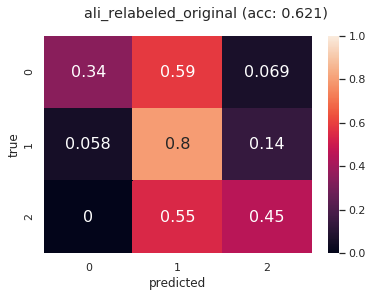

./data/generated_splits/peter_relabeled_original/eval/
['data/generated_splits/peter_relabeled_original/eval/1/IM-0010-0002-0001.dcm.png', 'data/generated_splits/peter_relabeled_original/eval/1/IM-0008-0003-0001.dcm.png', 'data/generated_splits/peter_relabeled_original/eval/1/IM-0019-0003-0001.dcm.png', 'data/generated_splits/peter_relabeled_original/eval/1/IM-0065-0029-0001.dcm.png', 'data/generated_splits/peter_relabeled_original/eval/1/IM-0024-0005-0001.dcm.png']
/data/jma/model/label_experiments/peter_relabeled_original/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/label_experiments/peter_relabeled_original/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_co

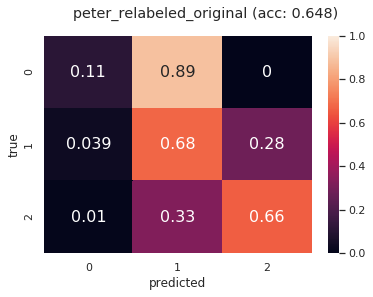

./data/generated_splits/ali_relabeled_undersampled/eval/
['data/generated_splits/ali_relabeled_undersampled/eval/1/IM-0040-0029-0001.dcm.png', 'data/generated_splits/ali_relabeled_undersampled/eval/1/IM-0052-0028-0001.dcm.png', 'data/generated_splits/ali_relabeled_undersampled/eval/1/IM-0019-0003-0001.dcm.png', 'data/generated_splits/ali_relabeled_undersampled/eval/1/IM-0063-0024-0001.dcm.png', 'data/generated_splits/ali_relabeled_undersampled/eval/1/IM-0051-0026-0001.dcm.png']
/data/jma/model/label_experiments/ali_relabeled_undersampled/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/label_experiments/ali_relabeled_undersampled/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 1000

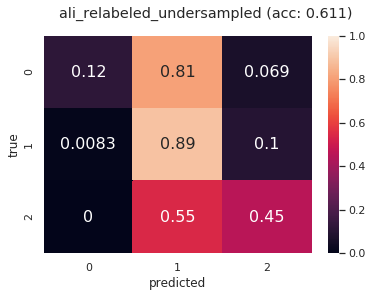

./data/generated_splits/peter_relabeled_undersampled/eval/
['data/generated_splits/peter_relabeled_undersampled/eval/1/IM-0010-0002-0001.dcm.png', 'data/generated_splits/peter_relabeled_undersampled/eval/1/IM-0008-0003-0001.dcm.png', 'data/generated_splits/peter_relabeled_undersampled/eval/1/IM-0019-0003-0001.dcm.png', 'data/generated_splits/peter_relabeled_undersampled/eval/1/IM-0065-0029-0001.dcm.png', 'data/generated_splits/peter_relabeled_undersampled/eval/1/IM-0024-0005-0001.dcm.png']
/data/jma/model/label_experiments/peter_relabeled_undersampled/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/label_experiments/peter_relabeled_undersampled/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_ever

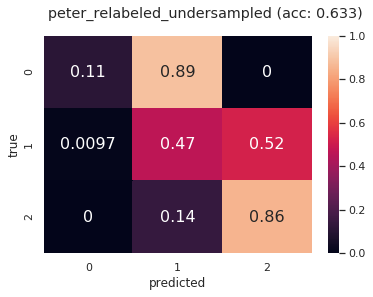

In [17]:
%matplotlib inline

import sklearn

tf.logging.set_verbosity(tf.logging.FATAL)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


tf.summary.FileWriterCache.clear()
b_size = 32


random_seed = 777

convnet_checkpoint_path_base = "/data/jma/model/label_experiments/"


# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.00]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


dataset_root = "./data/generated_splits/"

sets = ["ali_relabeled_original", 
        "peter_relabeled_original", 
        "ali_relabeled_undersampled", 
        "peter_relabeled_undersampled"]


for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:
                
                tf.logging.set_verbosity(tf.logging.INFO)
                
                eval_root = dataset_root + dt_set + "/eval/"
                   
                print(eval_root)
            
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                print(eval_paths[:5])
                
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)


                model_path = convnet_checkpoint_path_base + dt_set +"/"
                print(model_path)


                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                            num_channels=filter_size)
                model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

                values = model.predict(eval_input_fn)


                original_labels = path_to_label(eval_paths, eval_root)
                predicted_labels = list(values)

                
                accuracy = sklearn.metrics.accuracy_score(original_labels, predicted_labels)
                
                cm = tf.confusion_matrix(original_labels, predicted_labels)
                cm = tf.to_float(cm)

                cm = cm.numpy()

                row_sums = cm.sum(axis=1)
                cm = cm / row_sums[:, np.newaxis]

                df_cm = pd.DataFrame(cm, range(3), range(3))
                #plt.figure(figsize = (10,7))
                
                sns.set(font_scale=1)#for label size
                plt.suptitle(dt_set + " (acc: " + str('%.3f'%(accuracy)) + ")")
                ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, vmin=0, vmax=1.0)# font size
                ax.set(xlabel='predicted', ylabel='true')
                plt.show()
        

## Incorrectly Classified Images (PNG Format)

/data/jma/model/relabeled_data/resnet4/kernel5_filter8_snnl0.0/
in gpu part


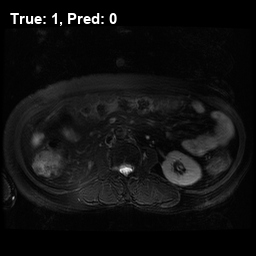

In [ ]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

resnet10_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet4/"

data_path = "./data/data_relabeled_png/"

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=5
filter_size=8
snnl_weight=0.0
#=========

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + "/"
print(model_path)

model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(working_input_fn)

original_labels = path_to_label(working_paths, data_path)
predicted_labels = list(values)

# make a plot?

for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
    